# SQL Query Composition

This notebook builds on previous notebooks that illustrate relatively simple SQL queries (queries with a single `SELECT` statement to retrieve and analyze BigQuery data). This notebooks illustrates how Google BigQuery allows you to use nested queries to create complex queries that successively filter or slice/dice results or perform joins in a single query issued to the service. Constructing these complex queries can often be made easier when done step-by-step.

This notebook introduces a pattern for developing queries independently, and then stitching them together to construct a complete solution.

## Scenario

As in other sample notebooks, this notebook will build on the HTTP logs dataset. The goal is to build a latency distribution curve of requests. This helps visualize the latency pattern of a web server.

**Preface on Notebook Content**

Although query composition through step-by-step building is intrinsically iterative, this notebook solution represents a snapshot of the final state. For illustrarive purposes, each step of the iteration is broken out into separate sections, but it's unlikely you'll do the same in a real-task scenario.

In [1]:
import datalab.bigquery as bq

# Step 1 - Inspecting Latencies

The first step is to get an initial slice of the data we're working with with a very basic query.

In [2]:
%%sql
SELECT latency FROM [cloud-datalab-samples:httplogs.logs_20140615] WHERE endpoint = 'Recent' LIMIT 10

latency
427
331
317
329
75
231
197
293
187
226


In [3]:
%%sql
SELECT MIN(latency) AS min, MAX(latency) AS max, COUNT(latency) AS count
FROM [cloud-datalab-samples:httplogs.logs_20140615]
WHERE endpoint = 'Recent'

min,max,count
2,18715,734


# Step 2 - Bucketing Latencies

Clearly, latencies are discrete numbers (milliseconds) over a wide range. One way to deal with this is to bucket them into groups.

In [4]:
%%sql --module latency
SELECT INTEGER(latency / 25) * 25 AS latency, COUNT(latency) AS requests
FROM [cloud-datalab-samples:httplogs.logs_20140615]
WHERE endpoint = 'Recent'
GROUP BY latency
ORDER BY latency

In [5]:
%bigquery execute --query latency

latency,requests
0,66
25,4
50,12
75,45
100,28
125,9
150,4
175,76
200,100
225,104


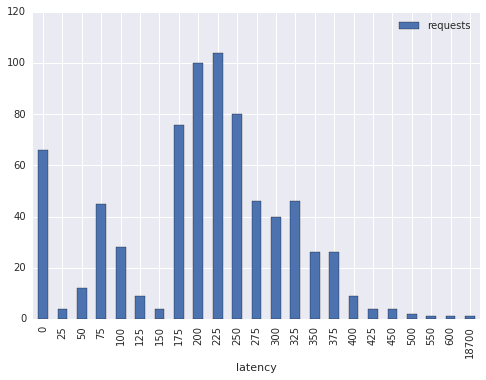

In [6]:
bq.Query(latency).to_dataframe().set_index('latency').plot(kind='bar')

# Step 3 - Latency Distribution

In this step, we want to determine the percentage of requests that fall within each bucket. In order to compute percentages, we need to issue a count query to determine counts, then use the buckets along with counts to produce percentage values.

In [7]:
%%sql --module latency

DEFINE QUERY buckets
  SELECT INTEGER(latency / 25) * 25 AS latency, COUNT(latency) AS requests
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Recent'
  GROUP BY latency
  ORDER BY latency

DEFINE QUERY stats
  SELECT COUNT(latency) AS total
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Recent'

SELECT bucket.latency AS latency,
       bucket.requests AS requests,
       bucket.requests * 100 / stats.total AS percent
FROM $buckets AS bucket CROSS JOIN $stats AS stats
ORDER BY latency

Notice that the first query was named`buckets` and the second was named `stats`, and these were referenced in the third query as `$buckets` and `$stats`, which uses the parameter syntax seen earlier to parameterize queries to pass in Python variables.

The third query was left as anonymous, and is treated as the _main_ query within the SQL module named `latency`. We can inspect the fully composed SQL represented by the module by creating a `Query` object and printing its `sql` property.

In [8]:
latency_distribution = bq.Query(latency)
print latency_distribution.sql

SELECT bucket.latency AS latency,
       bucket.requests AS requests,
       bucket.requests * 100 / stats.total AS percent
FROM (SELECT INTEGER(latency / 25) * 25 AS latency, COUNT(latency) AS requests
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Recent'
  GROUP BY latency
  ORDER BY latency) AS bucket CROSS JOIN (SELECT COUNT(latency) AS total
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Recent') AS stats
ORDER BY latency


Notice that the `buckets` and `stats` queries have been inlined as nested queries and used in a `JOIN`. The resulting SQL represents a single query that is issued and executed in BigQuery.

In [9]:
latency_distribution.results()

latency,requests,percent
0,66,8.99182561308
25,4,0.544959128065
50,12,1.6348773842
75,45,6.13079019074
100,28,3.81471389646
125,9,1.22615803815
150,4,0.544959128065
175,76,10.3542234332
200,100,13.6239782016
225,104,14.1689373297


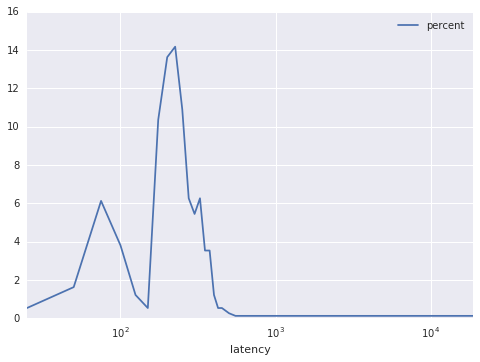

In [10]:
latency_distribution.to_dataframe().drop(['requests'], axis = 1).set_index('latency').plot(logx = True)

# Looking Ahead

Composing queries one step at a time and validating the results along the way (by either executing or sampling indermediate queries) allows you to build sophisticated queries while containing the complexity.

Look at some of the BigQuery samples for more examples.